# Image Classification - Hip Implant Use Case

**Import necessary libraries**

In [1]:
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Softmax)

2023-12-15 04:58:41.447109: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarni

**Define environment variables**

In [3]:
REGION = "us-central1"

PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

BUCKET_NAME = f"gs://{PROJECT_ID}-hip-implant"

os.environ["PROJECT_ID"] = PROJECT_ID
os.environ["REGION"] = REGION

In [4]:
!gsutil ls | grep ^{BUCKET_NAME}/$ || gsutil mb -l {REGION} {BUCKET_NAME}

gs://qwiklabs-asl-04-06351f77b64f-hip-implant/


**Create data pipeline**

In [5]:
CLASS_NAMES = ['loose', 'control']
NCLASSES = 2 # loose and control

def decode_csv(csv_row): # csv_row consists of a file path and the image class
    
    record_defaults = ["path", "image class"] # Default values for the dataset
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults) # tf.io.decode_csv reads every row in the csv
    
    image_bytes = tf.io.read_file(filename=filename) # output: base64 image string
    image_bytes = tf.image.decode_jpeg(image_bytes) # output: an integer array
    image_bytes = tf.image.convert_image_dtype(image_bytes, tf.float32) # output: 0 - 1 range float
    image_bytes = tf.image.resize(image_bytes, [224, 224]) # output: image dimension
    
    label = tf.math.equal(CLASS_NAMES, label_string) # formats label to a boolean array with a truth value corresponding to the output class
    
    return image_bytes, label # Returning a base64 image string and a boolean array with True corresponding to a particular class

In [6]:
def load_dataset(csv_file, batch_size, training=True):
    ds = tf.data.TextLineDataset(filenames=csv_file).skip(1) # skip(1) will remove the top row i.e. header
    ds = ds.map(decode_csv).cache() # mapping every row in the csv to decode_csv function defined above
    ds = ds.batch(batch_size=batch_size)
    
    if training:
        ds = ds.shuffle(10).repeat()
    return ds

**Create training dataset**

In [7]:
train_ds = load_dataset("gs://qwiklabs-asl-04-06351f77b64f-hip-implant/hip-implant-data.csv", batch_size = 10)

2023-12-15 04:58:46.046317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-15 04:58:46.057766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-15 04:58:46.062196: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
train_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.bool, name=None))>

**See the images in the training dataset**

2023-12-15 04:58:47.406894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-12-15 04:58:47.407480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-12-15 04:58:50.966702: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline 

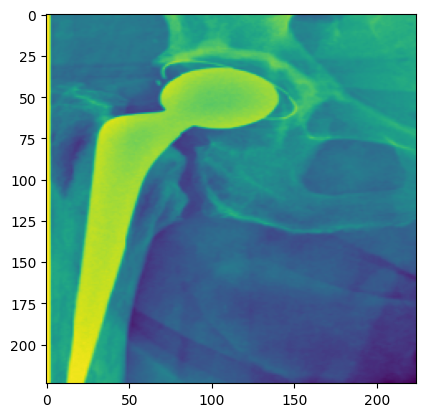

In [9]:
for i, l in train_ds.take(1):
    img = i[0]
    plt.imshow(img.numpy())

**Create the validation dataset**

In [ ]:
validation_data = load_dataset("gs://qwiklabs-asl-04-06351f77b64f-hip-implant/hip-implant-data.csv", batch_size = 10, training=False)

**Build the CNN model**

In [17]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 1

In [18]:
model = Sequential([
    Conv2D(name="first-Conv2D-layer",filters=64, kernel_size=3, input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), padding='same', activation='relu'),
    MaxPooling2D(name="first-pooling-layer",strides=2, padding='same'),
    Conv2D(name="second-Conv2D-layer", filters=32, kernel_size=3, activation='relu'),
    MaxPooling2D(name="second-pooling-layer", strides=2, padding='same'),
    Flatten(),
    Dense(units=400, activation='relu'),
    Dense(units=100, activation='relu'),
    Dropout(0.25),
    Dense(nclasses),
    Softmax()
])

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.fit(x=train_ds, validation_data=validation_data, epochs=5, steps_per_epoch=10)

Epoch 1/5


2023-12-15 04:58:51.542058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-12-15 04:58:51.542542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-12-15 04:58:55.595550: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-12-15 04:58:56.557799: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fca9e0dd7d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12

10/10 [==============================] - ETA: 0s - loss: 34.9856 - accuracy: 0.6800

2023-12-15 04:59:01.085061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 14s 840ms/step - loss: 34.9856 - accuracy: 0.6800 - val_loss: 17.9998 - val_accuracy: 0.4563
Epoch 2/5
10/10 [==============================] - 0s 51ms/step - loss: 4.6559 - accuracy: 0.4479 - val_loss: 0.8629 - val_accuracy: 0.5437
Epoch 3/5
10/10 [==============================] - 0s 34ms/step - loss: 0.8684 - accuracy: 0.4100 - val_loss: 0.8122 - val_accuracy: 0.4563
Epoch 4/5
10/10 [==============================] - 0s 34ms/step - loss: 0.8273 - accuracy: 0.3854 - val_loss: 0.7100 - val_accuracy: 0.5437
Epoch 5/5
10/10 [==============================] - 0s 35ms/step - loss: 0.7661 - accuracy: 0.3800 - val_loss: 0.6912 - val_accuracy: 0.5437


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first-Conv2D-layer (Conv2D)  (None, 224, 224, 64)     640       
                                                                 
 first-pooling-layer (MaxPoo  (None, 112, 112, 64)     0         
 ling2D)                                                         
                                                                 
 second-Conv2D-layer (Conv2D  (None, 110, 110, 32)     18464     
 )                                                               
                                                                 
 second-pooling-layer (MaxPo  (None, 55, 55, 32)       0         
 oling2D)                                                        
                                                                 
 flatten (Flatten)           (None, 96800)             0         
                                                        

**Create a pipeline to ingest input to the model for prediction**

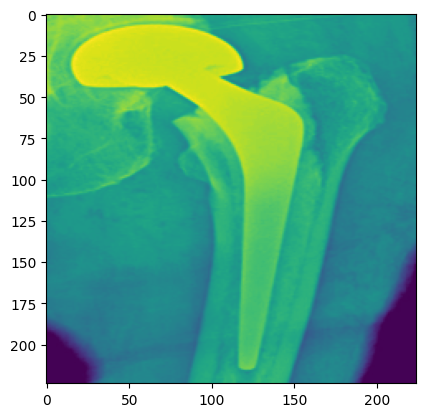

In [41]:
img = tf.io.read_file("gs://qwiklabs-asl-04-06351f77b64f-hip-implant/Control/control (26).png")

def decode_img(img, reshape_dims):
    img = tf.image.decode_jpeg(img) # tf.image.decode_jpeg can decode Base64 image string into an integer array
    #print("\n tf.image.decode_jpeg : Convert base64 image string into an integer array \n")
    #print(img)
    img = tf.image.convert_image_dtype(img, tf.float32) # tf.image.convert_image_dtype can cast the integer array into 0 -1 range float
    #print("\n tf.image.convert_image_dtype : Cast the integer array into 0 - 1 range float \n")
    #print(img)
    img = tf.image.resize(img, reshape_dims) # tf.image.resize can make image dimensions consistent for our neural network
    #print("\n tf.image.resize : Keep image dimensions consistent for our neural network \n")
    #print(img)
    return img


img = decode_img(img, [224, 224])

plt.imshow(img.numpy())

**Output pipeline**

In [136]:
def result(prediction):
    result = {0:'Loose',1:'Control'}
    prediction_value = prediction[0]
    max_predicted_value = max(prediction[0])
    index_max = np.where(prediction_value == max_predicted_value)
    index = index_max[0][0]
    return result[index]

**Predicting using a single image**

Image shape : (1, 224, 224, 1)
1/1 [==============================] - 0s 22ms/step
[[0.47367737 0.5263226 ]]
The model predicted :  Control

Actual Image


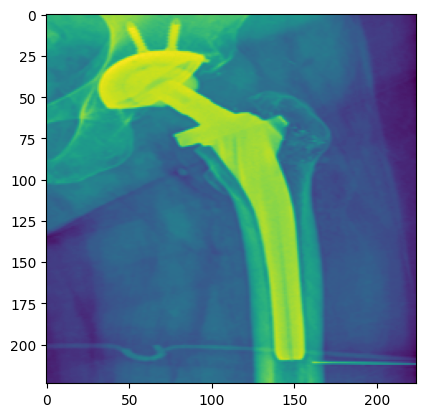

In [149]:
image_path = tf.io.read_file("gs://qwiklabs-asl-04-06351f77b64f-hip-implant/Loose/loose (5).png")
new_image = decode_img(image_path, [224, 224])
new_image_batch = np.stack((new_image,), axis=0)

print("Image shape :",new_image_batch.shape)

prediction = model.predict(new_image_batch)
print(prediction)
print("The model predicted : ", result(prediction))
print("\nActual Image")
plt.imshow(new_image)